## Clustering US 210 DMAs to sereveral segments

### Import Libraries

In [75]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import calinski_harabasz_score, adjusted_rand_score

import matplotlib.pyplot as plt

np.random.seed(0)
%matplotlib inline  

#### Market Data

In [76]:
market = pd.read_csv("Market_Segmentation.csv")
market.head()

,Unnamed: 0,DMA_Code,MEDIA,INDUSTRY,Audience Population,BRAND,Company,IsTop31,Spend_K,Division_Name
0,0,500,Int Display,Audio & Video Equipment & Supplies,892300,19.0,19.0,0.0,0.0,Northeast
1,1,500,Int Display,"Building Materials, Equipment & Fixtures",892300,3.0,3.0,0.0,0.0,Northeast
2,2,500,Int Display,Business & Technology NEC,892300,23.0,23.0,0.0,1.1,Northeast
3,3,500,Int Display,Communications,892300,21.0,21.0,0.0,0.0,Northeast
4,4,500,Int Display,"Computers, Software, Internet NEC",892300,207.0,207.0,0.0,3.9,Northeast


In [77]:
region = pd.read_csv('DMA_region.csv')

In [78]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7308 entries, 0 to 7307
Data columns (total 10 columns):
Unnamed: 0             7308 non-null int64
DMA_Code               7308 non-null int64
MEDIA                  7308 non-null object
INDUSTRY               7308 non-null object
Audience Population    7308 non-null int64
BRAND                  7308 non-null float64
Company                7308 non-null float64
IsTop31                7308 non-null float64
Spend_K                7308 non-null float64
Division_Name          7308 non-null object
dtypes: float64(4), int64(3), object(3)
memory usage: 571.1+ KB


In [79]:
market = market.drop(['Unnamed: 0'], axis=1)


In [80]:
market.head()

,DMA_Code,MEDIA,INDUSTRY,Audience Population,BRAND,Company,IsTop31,Spend_K,Division_Name
0,500,Int Display,Audio & Video Equipment & Supplies,892300,19.0,19.0,0.0,0.0,Northeast
1,500,Int Display,"Building Materials, Equipment & Fixtures",892300,3.0,3.0,0.0,0.0,Northeast
2,500,Int Display,Business & Technology NEC,892300,23.0,23.0,0.0,1.1,Northeast
3,500,Int Display,Communications,892300,21.0,21.0,0.0,0.0,Northeast
4,500,Int Display,"Computers, Software, Internet NEC",892300,207.0,207.0,0.0,3.9,Northeast


#### Data Dictionary

- MARKET: Designated Market Area (DMA) is a region where the population can receive the same television and radio station offerings, and may also include other types of media including newspapers and Internet content
- MEDIA: 10 Common Media Types including TV, Radio, Outdoor, Digital, etc.
- Audience Population: Population of TV/Radio Audience with age 12+
- Company/bRAND: Number of Companies/brands that advertise in this market
- IsTop31: A subjective category made from Telecom industry on Market Importance. 0 means is not Top 31 market, 1 means Top 31 market
- Spend_K: Media Spend in Thousands Dollars(000)

### Create Segments with KMeans Clustering as base model

In [81]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7308 entries, 0 to 7307
Data columns (total 9 columns):
DMA_Code               7308 non-null int64
MEDIA                  7308 non-null object
INDUSTRY               7308 non-null object
Audience Population    7308 non-null int64
BRAND                  7308 non-null float64
Company                7308 non-null float64
IsTop31                7308 non-null float64
Spend_K                7308 non-null float64
Division_Name          7308 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 514.0+ KB


#### Transform Categorical Value

In [82]:
#Change MARKETS to categorical 
market['DMA_Code']=market['DMA_Code'].astype('category')

In [83]:
#One Hot Encoding for Media and Industry

from sklearn.preprocessing import LabelBinarizer

def labelcoder(data, column):
    onehot = data.copy()
    lb=LabelBinarizer()
    lb_results = lb.fit_transform(onehot[column])
    lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
    return lb_results_df


In [84]:
media_features = labelcoder(market, 'MEDIA')
industry_features = labelcoder(market, 'INDUSTRY')
division_features = labelcoder(market, 'Division_Name')

#### Standardize Numerical Features

In [85]:
num_features = market[['Audience Population','BRAND','Company','IsTop31','Spend_K']]

from sklearn.preprocessing import MinMaxScaler
#Scale the numerical features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(num_features)
scaled_features = pd.DataFrame(scaled, columns = num_features.columns)

In [86]:
scaled_features

,Audience Population,BRAND,Company,IsTop31,Spend_K
0,0.048362,0.041096,0.041096,0.0,0.000000
1,0.048362,0.004566,0.004566,0.0,0.000000
2,0.048362,0.050228,0.050228,0.0,0.000018
3,0.048362,0.045662,0.045662,0.0,0.000000
4,0.048362,0.470320,0.470320,0.0,0.000063
...,...,...,...,...,...
7303,0.057031,0.004566,0.004566,0.0,0.000005
7304,0.057031,0.070776,0.070776,0.0,0.000471
7305,0.057031,0.004566,0.004566,0.0,0.000042
7306,0.057031,0.015982,0.015982,0.0,0.000071


In [87]:
market_df = pd.concat([market['DMA_Code'],scaled_features, media_features, industry_features, division_features], axis=1)

market_df.head()

,DMA_Code,Audience Population,BRAND,Company,IsTop31,Spend_K,Hispanic Newsp,Int Display,Local Mags,Local Radio,...,Manufactrg: Mtrls&Equip/Freight/Ind Dev,Media & Advertising,Misc Merchandise,Misc Services & Amusements,"Public Transportation, Hotels & Resorts",Retail,"Schools, Camps, Seminars",Central,Northeast,West
0,500,0.048362,0.041096,0.041096,0.0,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,500,0.048362,0.004566,0.004566,0.0,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,500,0.048362,0.050228,0.050228,0.0,0.000018,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,500,0.048362,0.045662,0.045662,0.0,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,500,0.048362,0.470320,0.470320,0.0,0.000063,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Set up base model

In [88]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=6, random_state=0).fit(market_df)
cluster_preds = k_means.predict(market_df)

#### Find the best K using Elbow Method

For each k value, initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [89]:
sum_of_squared_distances = []

K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(market_df)
    sum_of_squared_distances.append(km.inertia_)
       

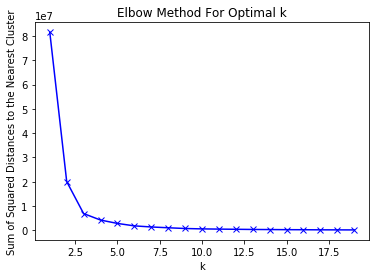

In [90]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances to the Nearest Cluster')
plt.title('Elbow Method For Optimal k')
plt.show()

The plot above the elbow looks like 3. Let's check performance of k=3,4, and 5

In [91]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0).fit(market_df)
cluster_preds = k_means.predict(market_df)
k_means.get_params

<bound method BaseEstimator.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)>

In [92]:
print(ch_score(market_df, cluster_preds))

39451.77110587817


In [93]:
n_clusters=3

In [94]:
k_means_cluster_stats = pd.DataFrame()
for i in range(n_clusters):
    k_means_cluster_stats['Cluster ' + str(i+1)] = market_df[k_means.labels_ == i].mean(axis=0)
      
k_means_cluster_stats = k_means_cluster_stats.T

In [95]:
k_means_cluster_stats

,DMA_Code,Audience Population,BRAND,Company,IsTop31,Spend_K,Hispanic Newsp,Int Display,Local Mags,Local Radio,...,Manufactrg: Mtrls&Equip/Freight/Ind Dev,Media & Advertising,Misc Merchandise,Misc Services & Amusements,"Public Transportation, Hotels & Resorts",Retail,"Schools, Camps, Seminars",Central,Northeast,West
Cluster 1,534.298432,0.145188,0.066869,0.066869,0.343981,0.001488,0.001183,0.295475,0.001775,0.056492,...,0.020704,0.117125,0.031352,0.087252,0.081337,0.090506,0.035492,0.452529,0.547471,0.000000
Cluster 2,794.438476,0.158859,0.062066,0.062066,0.358526,0.001993,0.003748,0.237352,0.000625,0.071205,...,0.013741,0.123673,0.024984,0.088070,0.083073,0.090568,0.035603,0.014366,0.000000,0.985634
Cluster 3,644.221410,0.099743,0.056599,0.056599,0.157782,0.000851,0.001290,0.279020,0.000000,0.042992,...,0.013328,0.130696,0.027945,0.084695,0.082545,0.093723,0.031814,0.424764,0.012038,0.563199


In [96]:
kmeans_market = market_df.copy()

In [97]:
kmeans_market['market_segments']=pd.DataFrame(cluster_preds)

### Try Hierachical Agglomerative Clustering

In [98]:
from sklearn.cluster import AgglomerativeClustering

agg_clt = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
agg_clt.fit(market_df)
agg_clt.get_params

<bound method BaseEstimator.get_params of AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')>

In [99]:
agg_clt_preds = agg_clt.fit_predict(market_df)

In [100]:
print(ch_score(market_df, agg_clt_preds))

22359.66911586388


The CH Score is higher for Kmeans clustering. We will stick with Kmeans clusters. 

### Interpret the Results

In [109]:
#Each DMA should be just in one cluster
kmeans_market.groupby('market_segments')['DMA_Code'].nunique()

market_segments
0    80
1    54
2    76
Name: DMA_Code, dtype: int64

In [110]:
kmeans_market_df = pd.merge(kmeans_market[['DMA_Code','market_segments']], market, left_on='DMA_Code', right_on='DMA_Code')

In [111]:
kmeans_market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376926 entries, 0 to 376925
Data columns (total 10 columns):
DMA_Code               376926 non-null category
market_segments        376926 non-null int32
MEDIA                  376926 non-null object
INDUSTRY               376926 non-null object
Audience Population    376926 non-null int64
BRAND                  376926 non-null float64
Company                376926 non-null float64
IsTop31                376926 non-null float64
Spend_K                376926 non-null float64
Division_Name          376926 non-null object
dtypes: category(1), float64(4), int32(1), int64(1), object(3)
memory usage: 28.0+ MB


In [112]:
kmeans_market_df2 = kmeans_market_df.merge(region[['DMA_Code','NIELSEN DMA']], left_on='DMA_Code', right_on='DMA_Code')

In [113]:
kmeans_market_df2.to_csv("market_clusters_results.csv")

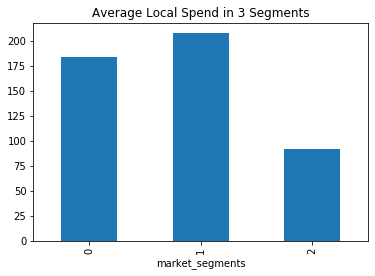

In [114]:
plt.title('Average Local Spend in 3 Segments')
plt.xlabel(['1','2','3'])
kmeans_market_df2.groupby('market_segments')['Spend_K'].mean().plot.bar()

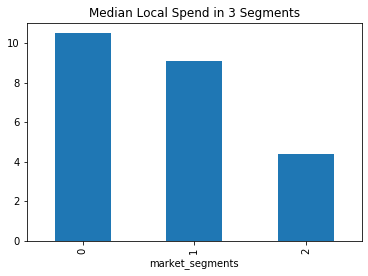

In [115]:
plt.title('Median Local Spend in 3 Segments')
kmeans_market_df2.groupby('market_segments')['Spend_K'].median().plot.bar()

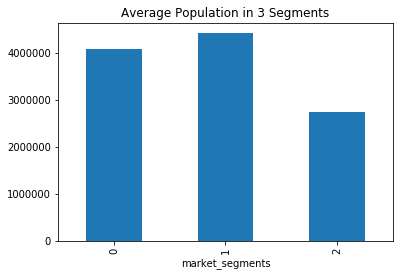

In [116]:
plt.title('Average Population in 3 Segments')
kmeans_market_df2.groupby('market_segments')['Audience Population'].mean().plot.bar()

In [117]:
kmeans_market_df2.groupby('market_segments').agg({'Audience Population':np.mean, 'Company':np.sum, 'Spend_K':np.mean})

,Audience Population,Company,Spend_K
market_segments,,,
0,4.088045e+06,7421173.0,183.904139
1,4.421629e+06,2673406.0,207.960846
2,2.739148e+06,3008325.0,91.643453
